## DATA606: Project 2
## Network communities and clustering

In this project we will exercise algorithms for network community analysis and clustering. Specifically, we will implement the Girvan-Newman community detection algorithm, and the k-mediods algorithm.

**Note**: We will need the igraph package for this. To install use `conda install -c conda_forge igraph-python`

Let's grab a toy network to try things out (this is the same network we used to illustrate the Girvan-Newman algorithm in lecture.

In [1]:
%load_ext autoreload
%autoreload 2

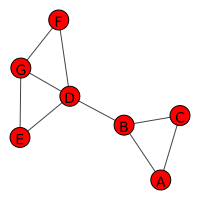

In [2]:
import numpy as np
import igraph

from networks_lib.toygraph import *

toy_mat = get_toy_mat()
plot_toy()

In [3]:
# This is the adjacency matrix for the graph
# rows and columns are in alphabetical order A-G
toy_mat

array([[0, 1, 1, 0, 0, 0, 0],
       [1, 0, 1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 1, 1, 1, 0]])

### Part A: Warm-up 

**Problem 1** What is the degree of each node in the graph?

**TODO**: Fill this in A: 2, B: 3, ...

**Problem 2** Compute degrees from the adjacency matrix and compare to your answer

In [4]:
## write out your answer to Problem 1
toy_deg_answer = np.array([2, 3, 2, 4, 2, 2, 3])

## compute the degrees from the adjacency matrix
toy_deg = np.zeros(toy_mat.shape[0])
toy_deg = toy_mat.sum(axis = 0)

## check this assertion passes
assert(np.all(toy_deg_answer == toy_deg))

**Problem 3** Use the adjacency matrix to find the neighbors of node F

In [5]:
## write out the neighbors of node F by hand (I gave you one of them)
f_neighbors_answer = np.array([3, 6])

## use the adjacency matrix to find the neighbors
f_neighbors = np.zeros(2)
f_neighbors = np.where(toy_mat[5] == 1)[0]

## check this assertion passes
assert(np.all(f_neighbors_answer == f_neighbors))

### Part B: All pairwise-distances

The distance between two nodes in the network is the length of the shortest path in the network. In this section we are going to use breadth-first-search to compute all pairwise distances.

The algorithm will roughly work as follows:

<pre>
Input: Adjacency matrix of size n by n  
Output: Distance matrix `dist` of size n by n  
    - For each vertex `u` in the network  
    - Create boolean array `visited` of length n   
    - Initialize all vertices u as `visited[u]=False`  
    - Push tuple `(u, 0)` to a (first-in-first-out) queue `Q`  
    - While `Q` is not empty:  
        - Pop tuple `(v,d)` from the top of `Q`  
        - Set `visited[v]=True`  
        - Set distance `dist[u,v]=d`  
        - For each neighbor `w` of `v`  
            - if `visited[w]=False`, push tuple `(w, d+1)` to `Q`  
</pre>

In python you can use the [collections.deque](https://docs.python.org/2/library/collections.html#collections.deque) module to implement the FIFO queue. You can `append` (to the right) to push, and `popleft` to pop (from the left).

**Problem 1** Implement and test the algorithm for all pairwise distances.

In [6]:
from networks_lib.distance import bfs_distance

## Write out by hand the distance matrix for our toy graph
## expected_dist[0:1,0:1] is correct below, fill in the rest
expected_dist = np.array([[0,1,1,2,3,3,3],
                          [1,0,1,1,2,2,2],
                          [1,1,0,2,3,3,3],
                          [2,1,2,0,1,1,1],
                          [3,2,3,1,0,2,1],
                          [3,2,3,1,2,0,1],
                          [3,2,3,1,1,1,0]])

## Implement your BFS all pairwise distance algorithm
## Do so in the `networks_lib.distance` module
toy_dist = bfs_distance(toy_mat)

## check this assertion is true
assert(np.all(expected_dist == toy_dist))

In [7]:
toy_dist

array([[0., 1., 1., 2., 3., 3., 3.],
       [1., 0., 1., 1., 2., 2., 2.],
       [1., 1., 0., 2., 3., 3., 3.],
       [2., 1., 2., 0., 1., 1., 1.],
       [3., 2., 3., 1., 0., 2., 1.],
       [3., 2., 3., 1., 2., 0., 1.],
       [3., 2., 3., 1., 1., 1., 0.]])

**Problem 2** Using distance to find graph components. Let's make a copy of the network adjacency matrix and remove edge `B-D`.

In [8]:
toy_copy = toy_mat.copy()
toy_copy[1,3] = 0
toy_copy[3,1] = 0
toy_copy

array([[0, 1, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 1, 1, 1, 0]])

The resulting network has two components (A,B,C) and (D,E,F,G). We can use a distance matrix to identify those components since any pair of nodes `u` and `v` for which `d(u,v)< np.inf` 
are reachable (means there is a path between `u` and `v`).

The procedure will roughly be:

<pre>
- mark all vertices are `unused`
- while any nodes are `unused`:
  - choose any unused node `u`
  - return `u` and all vertices `v` with `d(u,v) < np.inf` as a component and mark as used.
</pre>

In [9]:
from networks_lib.distance import get_components

## these are the expected components for the new graph
expected_components = [np.array([0,1,2]), np.array([3,4,5,6])]

## implement the component finding function based on your distance matrix
components = get_components(toy_copy)
#components = [np.zeros(3), np.zeros(4)]

## make this assertion pass
assert(all([np.all(x == y) for (x,y) in zip(expected_components,components)]))

In [10]:
components

[[0, 1, 2], [3, 4, 5, 6]]

### Part C: Edge Betweeness

In this section you will implement the edge betweenness algorithm described in book and lecture notes as part of the Girvan-Newman algorithm. 

**Problem 1** Implement the breadth-first algorithm to compute the number of shortest paths starting from a specific vertex going through each edge in the graph.

In [11]:
from networks_lib.betweenness import edge_counts

## Write out by hand a matrix containing the shortest path count starting from vertex E.
## In the result matrix entry i,j has the count for the edge i-j in the graph.
## This was shown as an example in lecture notes.
##
## expected_dist[0:1,0:1] is correct below, fill in the rest
expected_counts = np.array([[0, 1, 0, 0, 0, 0, 0],
                            [1, 0, 1, 3, 0, 0, 0],
                            [0, 1, 0, 0, 0, 0, 0],
                            [0, 3, 0, 0, 5, 1, 0],
                            [0, 0, 0, 5, 0, 0, 2],
                            [0, 0, 0, 1, 0, 0, 1],
                            [0, 0, 0, 0, 2, 1, 0]])

## implement the function edge_count 
counts = edge_counts(4, toy_mat)

## make sure this assertion passes
assert(np.all(counts == expected_counts))

In [12]:
counts

array([[0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 1., 3., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 3., 0., 0., 5., 1., 0.],
       [0., 0., 0., 5., 0., 0., 2.],
       [0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 2., 1., 0.]])

**Problem 2**: Confirm the edge betweenness function works properly by comparing result to
igraph's computation

In [14]:
from networks_lib.betweenness import edge_betweenness
from networks_lib.toygraph import get_toy_graph

## compute edge betweenness using igraph
g = get_toy_graph()
expected_betweenness = g.edge_betweenness()

## after implementing the `edge_counts` function above
toy_betweenness = edge_betweenness(toy_mat)
toy_betweenness
assert(np.all(expected_betweenness == np.triu(toy_betweenness)[np.where(np.triu(toy_mat)>0)]))

AssertionError: 

### Part D: Girvan-Newman community finding

Now we use all of the above to do community analysis on the graph.

The procedure should be as follows

<pre>
Input: adjacency matrix, and number of communities K
Output: array of community assignments

set components = [ [all vertices] ]
while number of components < K:
    - compute edge betweenness (edge_betweenness)
    - remove edge with highest edge betweenness
    - find components in the graph (get_components)
return an array with community assignments 
</pre>

In [61]:
import igraph
from networks_lib.toygraph import get_toy_graph
from networks_lib.communities import girvan_newman

## Let's use igraph to find 2 communities in the toy example
g = get_toy_graph()
expected_assignment = g.community_edge_betweenness(clusters=2).as_clustering().membership
expected_assignment

## Implement the girvan-newman algorithm
assignment = girvan_newman(toy_mat, 2)

## make this assertion pass
assert(np.all(assignment == np.array(assignment)))

### Part E: K-mediods clustering

Now we use K-mediods clustering on the graph distance matrix. We will build the algorithm in steps.

**Problem 1**: Implement random initialization 

In [23]:
from networks_lib.kmedioids import random_init
from networks_lib.distance import bfs_distance

toy_dist = bfs_distance(toy_mat)
medioids = random_init(toy_dist, 2)

assert(len(medioids) == 2)

In [24]:
medioids

[0, 6]

**Problem 2**: Now let's implement the assignment function, given medioids, assign each vertex
to the nearest medioid

In [45]:
from networks_lib.kmedioids import assign

# suppose vertices 'B' and 'E' are chosen
mediods = np.array([1, 4])

# correct this assignment
expected_assignment = np.array([1, 1, 1, 1, 4, 1, 4])

# compute assignment
assignment = assign(toy_dist, mediods)

assert(np.all(expected_assignment == assignment))

[[0. 1. 1. 2. 3. 3. 3.]
 [1. 0. 1. 1. 2. 2. 2.]
 [1. 1. 0. 2. 3. 3. 3.]
 [2. 1. 2. 0. 1. 1. 1.]
 [3. 2. 3. 1. 0. 2. 1.]
 [3. 2. 3. 1. 2. 0. 1.]
 [3. 2. 3. 1. 1. 1. 0.]] [1 4]


In [46]:
assignment

array([1., 1., 1., 1., 4., 1., 4.])

**Problem 3**: Now implement a function to determine medioids given an assignment

In [68]:
from networks_lib.kmedioids import get_medioids

# In this case all but 'A' are assigned to one cluster
assignment = np.array([0, 1, 1, 1, 1, 1, 1])

# what would the medioids be in that case?
expected_medioids = np.array([0, 3])

# implement the get_medioids function
medioids = get_medioids(toy_dist, assignment, 2)

# make this assertion work
assert(np.all(expected_medioids == medioids))

[[0. 1. 1. 2. 3. 3. 3.]
 [1. 0. 1. 1. 2. 2. 2.]
 [1. 1. 0. 2. 3. 3. 3.]
 [2. 1. 2. 0. 1. 1. 1.]
 [3. 2. 3. 1. 0. 2. 1.]
 [3. 2. 3. 1. 2. 0. 1.]
 [3. 2. 3. 1. 1. 1. 0.]] [0 1 1 1 1 1 1] 2
dists {0: 0.0}
dists {1: 8.0, 2: 12.0, 3: 6.0, 4: 9.0, 5: 9.0, 6: 8.0}


In [69]:
medioids

array([0., 3.])

**Problem 4**: Finish implementing k-medioids

In [78]:
from networks_lib.kmedioids import kmedioids

kmeds_assign = kmedioids(toy_dist, 2)
kmeds_assign

## make this assertion pass
assert(np.all(kmeds_assign < 2))

assign [[0. 1. 1. 2. 3. 3. 3.]
 [1. 0. 1. 1. 2. 2. 2.]
 [1. 1. 0. 2. 3. 3. 3.]
 [2. 1. 2. 0. 1. 1. 1.]
 [3. 2. 3. 1. 0. 2. 1.]
 [3. 2. 3. 1. 2. 0. 1.]
 [3. 2. 3. 1. 1. 1. 0.]] [4, 6]
[4. 4. 4. 4. 4. 6. 6.]
[[0. 1. 1. 2. 3. 3. 3.]
 [1. 0. 1. 1. 2. 2. 2.]
 [1. 1. 0. 2. 3. 3. 3.]
 [2. 1. 2. 0. 1. 1. 1.]
 [3. 2. 3. 1. 0. 2. 1.]
 [3. 2. 3. 1. 2. 0. 1.]
 [3. 2. 3. 1. 1. 1. 0.]] [4. 4. 4. 4. 4. 6. 6.] 2
ass {4.0: [0, 1, 2, 3, 4], 6.0: [5, 6]}
dists {0: 7.0, 1: 5.0, 2: 7.0, 3: 6.0, 4: 9.0}
dists {5: 1.0, 6: 1.0}
ret get medioids [1. 5.] [1, 5]
assign [[0. 1. 1. 2. 3. 3. 3.]
 [1. 0. 1. 1. 2. 2. 2.]
 [1. 1. 0. 2. 3. 3. 3.]
 [2. 1. 2. 0. 1. 1. 1.]
 [3. 2. 3. 1. 0. 2. 1.]
 [3. 2. 3. 1. 2. 0. 1.]
 [3. 2. 3. 1. 1. 1. 0.]] [1, 5]
[1. 1. 1. 1. 1. 5. 5.]
[[0. 1. 1. 2. 3. 3. 3.]
 [1. 0. 1. 1. 2. 2. 2.]
 [1. 1. 0. 2. 3. 3. 3.]
 [2. 1. 2. 0. 1. 1. 1.]
 [3. 2. 3. 1. 0. 2. 1.]
 [3. 2. 3. 1. 2. 0. 1.]
 [3. 2. 3. 1. 1. 1. 0.]] [1. 1. 1. 1. 1. 5. 5.] 2
ass {1.0: [0, 1, 2, 3, 4], 5.0: [5, 6]}
dists {0: 7.0, 1: 

AssertionError: 